In [1]:
#General imports
import collections
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
#Figure settings to avoid super large plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 90

# Session 4: Building a model from scratch (I)

In the next 2 sessions, we will follow all the steps required to build a Machine Learning model **addressing a real problem**. We will also do it in an *artisanal* way, from scratch, in order to understand all the subtleties and details that in practice make the difference between a successful system and one that fails miserably.

Specifically, the procedure involves:
 1. Learning about the problem to be solved.
 2. Understanding the available data.
 3. Data cleaning, preparation and homogeneization.
 4. Design of experimental validation.
 5. Choose a model or set of models to evaluate.
 6. Training and evaluating the model(s).
 7. Extract conclusions, assess the limitations of the model.


## 1. The problem: Electrocardiogram (ECG) classification

The ECG is a multi-channel biosignal generated from the projections of the **electrical activity of the heart** at different locations in the body. It provides information about heart rate, conduction, and can indicate issues like arrhythmias.

### Example of a normal ECG

<video style="float:left" width="22%" src="assets/sr_anim.mp4" autoplay="true" loop="true" muted="true">
</video>

<img style="float:right;margin-top:15pt" width="72%" src="assets/A00848.svg">

### Example of an arrhythmia: Atrial Fibrillation

<video style="float:left" width="22%" src="assets/afib_anim.mp4" autoplay="true" loop="true" muted="true">
</video>

<img style="float:right;margin-top:15pt" width="72%" src="assets/A00326.svg">

Our objective will be, given an isolated heartbeat, **determine the heart area** where it has been generated. This information is extremely relevant for physicians to make a diagnosis or predict possible future cardiac complications.

## 2. The data: MIT-BIH Arrhythmia Database

To tackle this interesting problem, we will use an open dataset: [The MIT-BIH Arrhythmia Database](https://physionet.org/content/mitdb/1.0.0/):
 - It includes **48 half-hour annotated ECG excerpts with 2 channels sampled at 360Hz**.
 - Widely used in research for testing and **evaluating ECG analysis** algorithms.

The data is provided in the [WFDB](https://wfdb.io/) format. Fortunately, there is a convenient Python library that does all the dirty work to access the data:

In [2]:
import wfdb
#Local path to the MIT-BIH Arrhythmia
MITDB = '/home/teijeiro/data/mitdb'

There is a plain text index file with the identifiers of all ECG recordings:

In [3]:
rec_list = open(f'{MITDB}/RECORDS', 'r').readlines()
#Side effect of readlines: the \n is at the end of each element
rec_list = [r.strip() for r in rec_list]
print(rec_list)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']


Let's load one of the recordings and see the information it provides:

In [4]:
rec = wfdb.rdrecord(f'{MITDB}/100')
rec.__dict__

{'record_name': '100',
 'n_sig': 2,
 'fs': 360,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 650000,
 'base_time': None,
 'base_date': None,
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'sig_name': ['MLII', 'V5'],
 'p_signal': array([[-0.145, -0.065],
        [-0.145, -0.065],
        [-0.145, -0.065],
        ...,
        [-0.675, -0.365],
        [-0.765, -0.335],
        [-1.28 ,  0.   ]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['100.dat', '100.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [1024, 1024],
 'units': ['mV', 'mV'],
 'adc_res': [11, 11],
 'adc_zero': [1024, 1024],
 'init_value': [995, 1011],
 'checksum': [-22131, 20052],
 'block_size': [0, 0]}

We can visualize the first 10 seconds of the signal, to get a feeling of how it looks like and if everything is as expected:

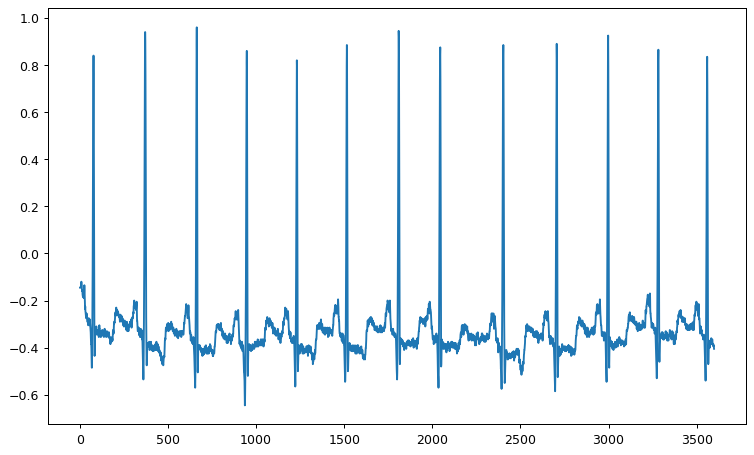

In [5]:
import matplotlib.pyplot as plt
plt.plot(rec.p_signal[:10*rec.fs,0])

#### 📋 Exercise 1
The recordings were supposed to be annotated. According to the database description, find this information and load it for the recording we just visualized.

__Hints:__
 - The [WFDB format specification](https://wfdb.io/spec/) may help you.
 - The [WFDB Python API](https://wfdb.readthedocs.io/en/latest/) may help you even more.

In [6]:
# Complete the code to provide a solution to Exercise 1
anns = wfdb.rdann(f'{MITDB}/100', 'atr')

Each annotation contains basically two pieces of information:
 1. The signal sample in which it happens.
 2. A code with the meaning of the annotation.

Since we want to classify each individual heartbeat, we are looking for *beat annotations*. 
```
Beat annotation codes:
N   Normal beat
L   Left bundle branch block beat
R   Right bundle branch block beat
B   Bundle branch block beat (unspecified)
A   Atrial premature beat
a   Aberrated atrial premature beat
J   Nodal (junctional) premature beat
S   Supraventricular premature or ectopic beat (atrial or nodal)
V   Premature ventricular contraction
r   R-on-T premature ventricular contraction
F   Fusion of ventricular and normal beat
e   Atrial escape beat
j   Nodal (junctional) escape beat
n   Supraventricular escape beat (atrial or nodal) [1]
E   Ventricular escape beat
/   Paced beat
f   Fusion of paced and normal beat
Q   Unclassifiable beat
?   Beat not classified during learning

Non-beat annotation codes:
[   Start of ventricular flutter/fibrillation
!   Ventricular flutter wave
]   End of ventricular flutter/fibrillation
x   Non-conducted P-wave (blocked APC) [4]
(   Waveform onset [4]
)   Waveform end [4]
p   Peak of P-wave [4]
t   Peak of T-wave [4]
u   Peak of U-wave [4]
‘   PQ junction
’   J-point
^   (Non-captured) pacemaker artifact
|   Isolated QRS-like artifact [2]
~   Change in signal quality [2]
+   Rhythm change [3]
s   ST segment change [1,3]
T   T-wave change [1,3,4]
*   Systole [1]
D   Diastole [1]
=   Measurement annotation [1,3]
"   Comment annotation [3]
@   Link to external data [5]
```

There are **19 different classification codes** for heartbeats. Let's do a quick check to see the distribution in the whole database.

In [7]:
BEAT_CODES = set(['N','L','R','B','A','a','J','S','V','F','e','j','n','E','/','f','Q'])
all_anns = sum([wfdb.rdann(f'{MITDB}/{rec}', 'atr').symbol for rec in rec_list], [])
beat_anns = [a for a in all_anns if a in BEAT_CODES]
collections.Counter(beat_anns)

Counter({'N': 75052,
         'L': 8075,
         'R': 7259,
         'V': 7130,
         '/': 7028,
         'A': 2546,
         'f': 982,
         'F': 803,
         'j': 229,
         'a': 150,
         'E': 106,
         'J': 83,
         'Q': 33,
         'e': 16,
         'S': 2})

With this class distribution, it is evident the **problem would be ill-posed** from a machine learning perspective (we cannot learn a class with 2 or 16 samples out of ~100000).

Fortunately, experts already realized that, and created a simplified version of the labels, with the following equivalence:

| AAMI | MIT-BIH equivalent classes |
|------|----------------------------|
| N    | N, L, R, B                 |
| S    | a, J, A, S, j, e, n        |
| V    | V, E                       |
| F    | F                          |
| Q    | /, f, Q                    |

Let's implement this equivalence with a map. We encode the new labels as integers, as it will be useful later to feed the ML models:

In [8]:
LABEL_MAP = {'N':0,'L':0,'R':0,'B':0,
             'A':1,'a':1,'J':1,'S':1,'e':1,'j':1,'n':1,
             'V':2,'E':2,
             'F':3,
             '/':4,'f':4,'Q':4}

#### 📋 Exercise 2
 - Convert the `beat_anns` list to the new codes defined by LABEL_MAP, and get the statistics for the new set.

In [9]:
# Complete the code to solve Exercise 2
new_beat_anns = [LABEL_MAP[a] for a in beat_anns]
collections.Counter(new_beat_anns)

Counter({0: 90386, 4: 8043, 2: 7236, 1: 3026, 3: 803})

Still, it is a highly unbalanced problem. But at least we have roughly ~1000 samples for the least represented class, which should be in principle sufficient for some learning.

## 3. Preparing the data

### Main question: What information is required for our objective?

 - **Data we have**: Raw signal from 2 channels + position and annotation of each individual beat.

#### 💡 Open discussion:

From your current expertise on ECG analysis, what **information** do you think it's **relevant** and how you can get it from the data?


In [10]:
# Creation of a Pandas dataframe with homogeneized data for every beat
full_data = []
for r in rec_list:
    rec = wfdb.rdrecord(f'{MITDB}/{r}')
    anns = wfdb.rdann(f'{MITDB}/{r}', 'atr')
    beat_mask = np.array([s in BEAT_CODES for s in anns.symbol])
    beat_indices = np.where(beat_mask)[0]
    beat_types = np.array(anns.symbol)[beat_indices]
    beat_locations = anns.sample[beat_indices]
    for i in range(1, len(beat_indices)-1):
        beat_data = {}
        beat_data['beat_sig'] = rec.p_signal[beat_locations[i-1]:beat_locations[i+1],:]
        beat_data['peak'] = beat_locations[i]-beat_locations[i-1]
        beat_data['length'] = len(beat_data['beat_sig'])
        beat_data['type'] = LABEL_MAP[beat_types[i]]
        beat_data['leads'] =  rec.sig_name
        beat_data['recname'] = rec.record_name
        full_data.append(beat_data)
df_beats = pd.DataFrame(full_data)
display(df_beats.head())
display(df_beats.describe())

,beat_sig,peak,length,type,lead_0,lead_1,recname
0,"[[0.84, 0.21], [0.765, -0.085], [0.52, -0.23],...",293,585,0,MLII,V5,100
1,"[[0.94, 0.36], [0.905, 0.105], [0.755, -0.165]...",292,576,0,MLII,V5,100
2,"[[0.885, 0.61], [0.96, 0.32], [0.85, -0.045], ...",284,569,0,MLII,V5,100
3,"[[0.81, 0.545], [0.86, 0.23], [0.77, -0.105], ...",285,569,0,MLII,V5,100
4,"[[0.82, 0.155], [0.78, -0.17], [0.535, -0.38],...",284,578,0,MLII,V5,100


,peak,length,type
count,109398.000000,109398.000000,109398.000000
mean,284.925053,569.854111,0.475676
std,136.626337,212.359943,1.143253
min,90.000000,194.000000,0.000000
25%,236.000000,478.000000,0.000000
50%,275.000000,547.000000,0.000000
75%,321.000000,636.000000,0.000000
max,36008.000000,36828.000000,4.000000


If we check the distribution of the `peak` and `length` variables, there is clearly something atypical by considering the difference of the 75% quartile with respect to the maximum value. By plotting the distribution:

<Axes: xlabel='length', ylabel='Density'>

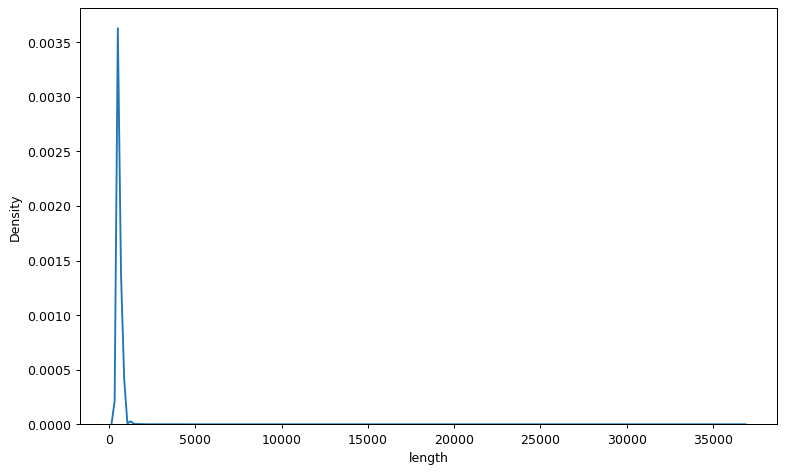

In [11]:
sns.kdeplot(df_beats.length)

Even restricting to an extremely high percentile (99.9%), the value would be much closer to what could be expected from a normal distribution:

In [12]:
#99.9% distribution of beat length compared to what would correspond in a gaussian distribution
print(np.percentile(df_beats.length, [99.9])[0])
print(scipy.stats.norm.ppf(.999, loc=df_beats.length.mean(), scale=df_beats.length.std()))

1444.2060000000347
1226.095665880563


It's also interesting to check where the peaks is usually located within the duration of the beat. Intuition says it should be around the half point, but let's check the actual distribution. Fortunately, in this case nothing weird happens:

<Axes: ylabel='Density'>

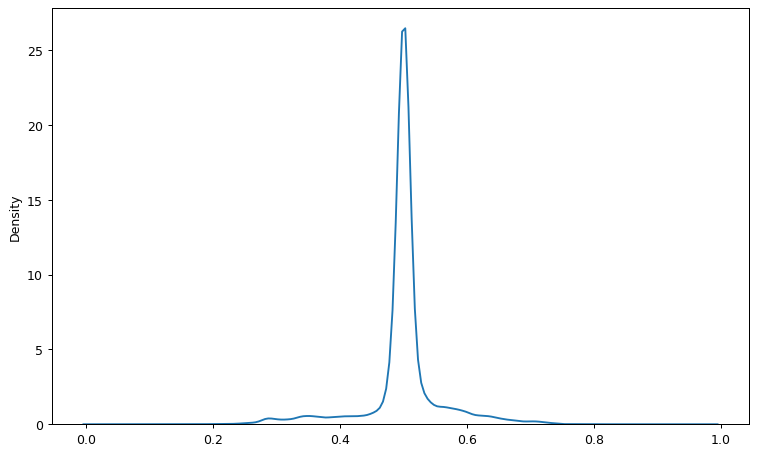

In [13]:
sns.kdeplot(df_beats.peak/df_beats.length)

Then, to make things convenient and avoid biasing too much the exploration to the available data, let's select a **window of 1501 samples**, with the **peak at sample 750**. For this, we need to homogeneize the `length` of each beat to 1501 samples, centered at the peak location. Then, `peak` and `length` attributes would be no longer needed.

 - Fortunately, commercial LLM models like ChatGPT can be useful to generate this kind of boilerplate code:

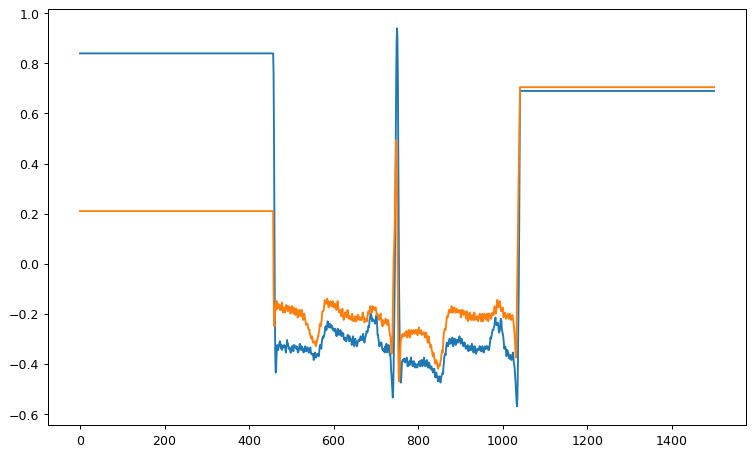

In [14]:
def adjust_array_length(arr, peak):
    desired_length = 1501
    target_peak_index = 750
    current_length = len(arr)

    start_index = max(0, peak - target_peak_index)
    end_index = min(current_length, peak + (desired_length - target_peak_index))

    # Truncate the array around the peak
    truncated_array = arr[start_index:end_index, :]

    left_padding = target_peak_index - (peak - start_index)
    right_padding = desired_length - len(truncated_array) - left_padding

    # Extend the array if needed
    if left_padding > 0:
        left_pad_value = truncated_array[0, :]
        left_extension = np.full((left_padding, 2), left_pad_value)
    else:
        left_extension = np.empty(shape=(0, 2))

    if right_padding > 0:
        right_pad_value = truncated_array[-1, :]
        right_extension = np.full((right_padding, 2), right_pad_value)
    else:
        right_extension = np.empty(shape=(0, 2))

    # Combine the extensions and truncated array
    adjusted_array = np.concatenate((left_extension, truncated_array, right_extension))

    return adjusted_array

#Test the function with a specific example
arr = df_beats.iloc[0].beat_sig
peak = df_beats.iloc[0].peak
plt.plot(adjust_array_length(arr, peak))

We can see one main issue of the approach we took to isolate each beat: By taking the signal from the previous and up to the next beat, the border effects are very large.

A quick and dirty solution would be to start each beat window a little after the previous peak, and stop it a little before the next one. Making an informed decision, we can check that the typical **[QRS duration](https://litfl.com/qrs-interval-ecg-library/) is between 70 and 100ms**. So we can cut the window 50ms on each side (18 samples).

#### 📋 Exercise 3

Improve the `df_beats` dataset by applying the abovementioned offset (18 samples) at the border of each heartbeat. Then homogeneize the `length` of each beat to 1501 samples, centered at the peak location. After this, you can safely remove the `peak` and `length` attributes from the dataframe.

__Hint__:
 - Use the `adjust_array_length` function just defined.

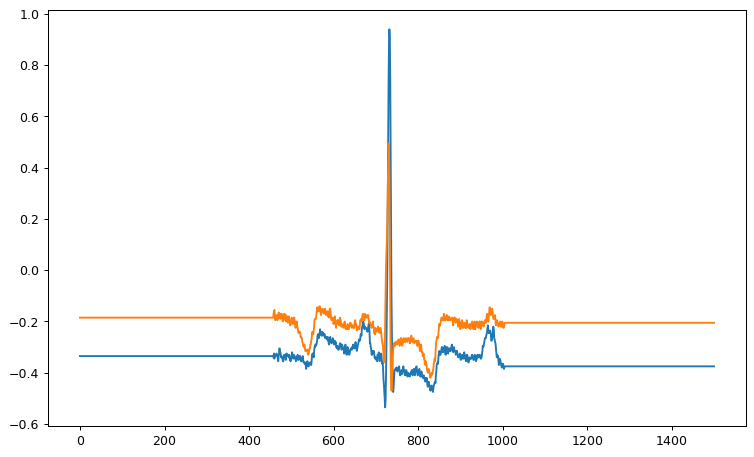

In [15]:
# Complete the code to solve Exercise 3
# Creation of a Pandas dataframe with homogeneized data for every beat
full_data = []
offset = 18 #Window cut with respect to previous and next peak.
for r in rec_list:
    rec = wfdb.rdrecord(f'{MITDB}/{r}')
    anns = wfdb.rdann(f'{MITDB}/{r}', 'atr')
    beat_mask = np.array([s in BEAT_CODES for s in anns.symbol])
    beat_indices = np.where(beat_mask)[0]
    beat_types = np.array(anns.symbol)[beat_indices]
    beat_locations = anns.sample[beat_indices]
    for i in range(1, len(beat_indices)-1):
        beat_data = {}
        beat_data['beat_sig'] = adjust_array_length(rec.p_signal[beat_locations[i-1]
                                                    + offset:beat_locations[i+1]-offset,:],
                                                    beat_locations[i]-beat_locations[i-1])
        beat_data['type'] = LABEL_MAP[beat_types[i]]
        beat_data['leads'] =  rec.sig_name
        beat_data['recname'] = rec.record_name
        full_data.append(beat_data)
df_beats = pd.DataFrame(full_data)
#Test again the homogeneization function with a specific example
plt.plot(df_beats.iloc[0].beat_sig)

Much better!! 😀 Now we can start doing some database-wide exploration. Let's get a sample of 10k beats to be more agile, as it shouldn't have major impact on general statistics.

In [16]:
df_sample = df_beats.sample(n=10000, random_state=42)
#Now we create a matrix with all the samples
sig_matrix = np.hstack(df_sample.beat_sig).T
sig_matrix.shape

(20000, 1501)

Let's visualize the distribution of the shape of the beats:

<Axes: >

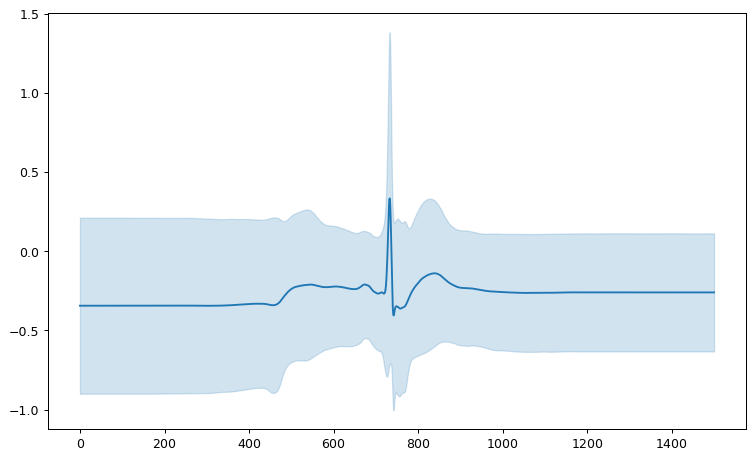

In [17]:
time = np.tile(np.arange(1501), len(sig_matrix))
amp = sig_matrix.flatten()
sns.lineplot(x=time, y=amp, errorbar='sd')

Fortunately it indeed looks like a beat! However, the variance is extremely large, and specially in the borders it suggests beats have a **constant bias in the baseline**.

#### 📋 Exercise 4

Remove the baseline bias of all the beats, and visualize again the distribution in time of the homogeneized beat windows.

__Hints:__
 - The easiest way would be to make every beat have 0-mean. However, we can see from the figure above that the amplitude is highly asymmetric. Maybe other statistics work better...

<Axes: >

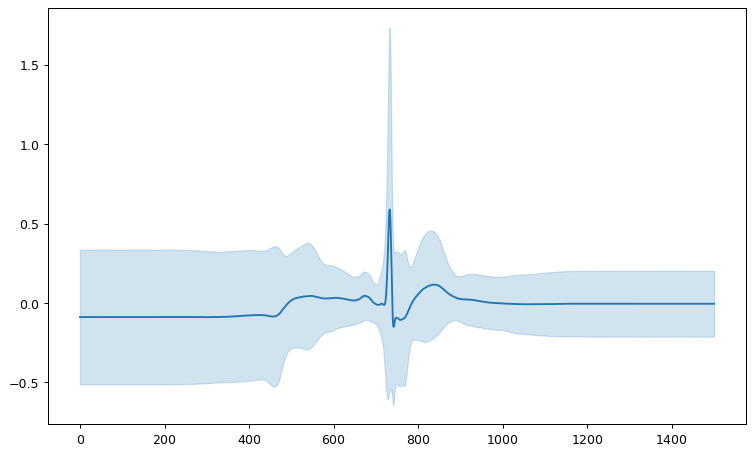

In [18]:
# Complete the code to solve Exercise 4:
#Let's try with 0-median
sig_matrix = sig_matrix - np.median(sig_matrix, axis=1, keepdims=True)
amp = sig_matrix.flatten()
sns.lineplot(x=time, y=amp, errorbar='sd')

The variance has indeed reduced a lot. Still, we are **mixing signals from different leads and also different classes** of beats. Let's get a feeling of how different leads look like.

First we get the set of all leads, and basic statistics about their prevalence:

In [19]:
leads = np.array(sum(df_sample.leads.values,[]))
collections.Counter(leads)

Counter({'MLII': 9589, 'V1': 8540, 'V5': 977, 'V2': 736, 'V4': 158})

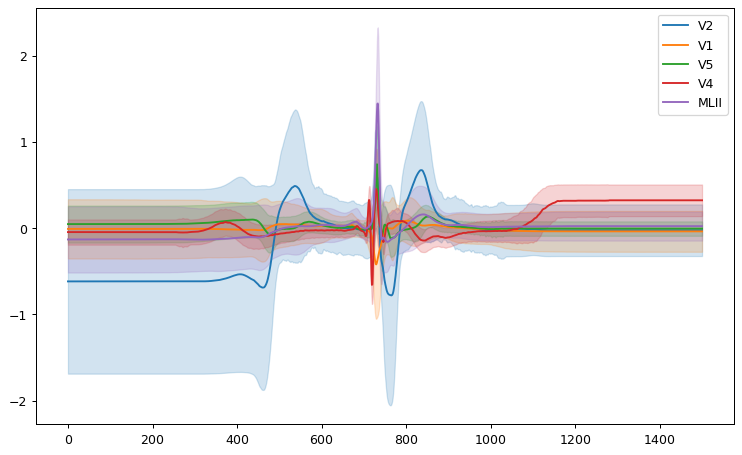

In [20]:
for l in set(leads):
    lead_beats = np.where(leads==l)[0]
    submatrix = sig_matrix[lead_beats, :]
    nbeats, wlen = submatrix.shape
    time = np.tile(np.arange(wlen), nbeats)
    amp = submatrix.flatten()
    sns.lineplot(x=time, y=amp, errorbar='sd', label=l)

Definitely they look **pretty different**, so we need to take this into consideration.

#### 📋 Exercise 5

Do the same kind of visual analysis we did for different leads, but in this case for beat classes.

__Hints__:
 - The `type` attribute corresponding to the classes is associated to each row of the dataframe, that contains two signals. `np.repeat` can be useful to fit the target size of the classes vector with `sig_matrix`.

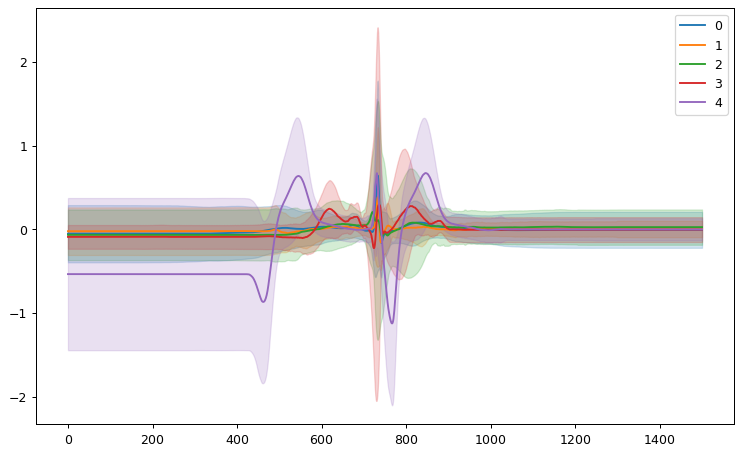

In [21]:
#Provide the code to solve Exercise 5:
classes = np.repeat(df_sample.type, 2)
for k in set(classes):
    class_beats = np.where(classes==k)[0]
    submatrix = sig_matrix[class_beats, :]
    nbeats, wlen = submatrix.shape
    time = np.tile(np.arange(wlen), nbeats)
    amp = submatrix.flatten()
    sns.lineplot(x=time, y=amp, errorbar='sd', label=k)

Surprisingly (and worryingly 😟) it seems there is a strong correlation between some classes and some leads. This suggests there can be potential bias in how some classes have been acquired. Let's quickly measure this bias:

In [22]:
#We measure the percentage of each lead for each beat type.
for k in set(classes):
    lk = leads[classes==k]
    percentages = {k: int(v / len(lk) * 100) for k, v in collections.Counter(lk).items()}
    print(f'Class {k}: ' + str(percentages))

Class 0: {'MLII': 49, 'V1': 43, 'V5': 3, 'V2': 2, 'V4': 0}
Class 1: {'MLII': 50, 'V1': 48, 'V5': 0, 'V4': 0, 'V2': 0}
Class 2: {'MLII': 49, 'V1': 49, 'V4': 0, 'V5': 0, 'V2': 0}
Class 3: {'MLII': 50, 'V1': 48, 'V5': 1}
Class 4: {'MLII': 23, 'V1': 23, 'V5': 26, 'V2': 26}


To make a more **robust and general model**, it seems clearly justified we should:
 - Remove class 4.
 - Remove leads V5, V2 and V4.

In [23]:
df_sample2 = df_sample.query('type!=4')
leads_mask = df_sample2.leads.apply(lambda leads:set(['V5', 'V2', 'V4']).isdisjoint(set(leads)))
df_sample2 = df_sample2[leads_mask]
print(len(df_sample2))

8203


At this point, it is usually a good idea to test a simple ML model to get an idea of how difficult the problem is.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
# Prepare the X and y matrices
X = np.hstack(df_sample2.beat_sig).T
X = X - np.median(X, axis=1, keepdims=True)
y = np.repeat(df_sample2.type, 2)
# Split in training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create the model, train it and test it
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
# Display the confusion matrix and the classification report
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['True 0', 'True 1', 'True 2', 'True 3'], columns=['Pred 0', 'Pred 1', 'Pred 2', 'Pred 3'])
display(cm_df)
display(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose().round(2))

,Pred 0,Pred 1,Pred 2,Pred 3
True 0,2920,0,6,0
True 1,51,55,2,0
True 2,47,0,179,3
True 3,5,0,3,11


,precision,recall,f1-score,support
0,0.97,1.00,0.98,2926.00
1,1.00,0.51,0.67,108.00
2,0.94,0.78,0.85,229.00
3,0.79,0.58,0.67,19.00
accuracy,0.96,0.96,0.96,0.96
macro avg,0.92,0.72,0.79,3282.00
weighted avg,0.96,0.96,0.96,3282.00


Wow, results are really encouraging!🤩. Consider that:
 - No feature engineering has been performed at all.
 - The model used is simple, without hyperparameter tuning.
 - The classification performance is rather good for all classes.
 - Errors come mostly from non-normal beats classified as normal, probably due to class imbalance.

Therefore, we may be tempted to consider the problem as *almost-solved*, just a few tweaks here and there missing to optimize the results a bit more. Right?

<p style="font-size:400%;color:darkred;text-align:center">⚠️⚠️ WRONG!!! ⚠️⚠️</p>

The last, quick experiment with a simple ML model is **fundamentally wrong**, and any conclusion we may get from it will be misleading!

But this is a topic for the next session...